**Izhikevich model**


Membrane potential:
$$ v'=0.04v^2+5v-u+140+I_{app}+I_{syn}$$

Membrane recovery:
$$ u'=a(bv-u) $$

$I_{app}$ is the externally applied current and is constant in our implementation. $I_{syn}$ is the neuronal synchronization term.

$$I^{i}_{syn} = \sum_{k \rightarrow i} \frac{g^{i}_{syn}(E_{syn}-v^{i})}{1+e^{-\frac{v^k}{k_{syn}}}}$$

$g_{syn}$ is the synaptic weight and is also a constant. 

In [ ]:
from __future__ import print_function
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
#import tensorflow.compat.v2 as tf2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
class RC_Izh(object):
  
  def __init__(self, n=10, A=None, B=None, C=None, D=None, G_syn=None, E_syn=None, K_syn=None, 
               spiking_thres=35.0, resting_potential=-70.0, p=0.2):

        # The number of neurons
        self.n = n
        if A is None:
          self.A = np.full((n), 0.02, dtype=np.float32)
        else:
          self.A = A
        if B is None:
          self.B = np.full((n), 0.2, dtype=np.float32)
        else:
          self.B = B
        if C is None:
          self.C = np.full((n), -65.0, dtype=np.float32)
        else:
          self.C = C
        if D is None:
          self.D = np.full((n), 8.0, dtype=np.float32)
        else:
          self.D = D
        if G_syn is None:
          self.G_syn = np.full((n), 0.1, dtype=np.float32)
        else:
          self.G_syn = G_syn
        if E_syn is None:
          self.E_syn = np.full((n), 0.0, dtype=np.float32)
        else:
          self.E_syn = E_syn
        if K_syn is None:
          self.K_syn = np.full((n), 0.2, dtype=np.float32)
        else:
          self.K_syn = K_syn
          
        self.spiking_thres = spiking_thres
        self.resting_potential = resting_potential

        self.p = p
        # Instantiate a specific tensorflow graph for the Neuron Model
        self.graph = tf.Graph()
        
        ################################
        # Build the neuron model graph #
        ################################
        with self.graph.as_default():

            ##############################
            # Variables and placeholders #
            ##############################    
            self.get_vars_and_ph()
            # Operations to evaluate the membrane response (potential v and recovery u)
            self.potential, self.recovery = self.get_response()

  def get_vars_and_ph(self):
    self.v = tf.Variable(tf.constant(self.resting_potential, shape=[self.n], dtype=tf.float32), name='v')
    self.u = tf.Variable(self.B*self.C, name='u')
    self.I = tf.placeholder(tf.float32, shape=[self.n])
    self.dt = tf.placeholder(tf.float32)
    self.adj_mat = tf.Variable(self.adj_mat_generator(), name='adj_mat')
    self.adj_mat = tf.linalg.set_diag(self.adj_mat, tf.zeros([self.n], dtype=tf.float32))

  # generate a random adjacency matrix for neurons with given connection probability 
  def adj_mat_generator(self):
    adj_m = tf.random_uniform([self.n, self.n], dtype=tf.float32)
    adj_m = tf.where(adj_m < tf.constant(self.p, shape=[self.n,self.n], dtype=tf.float32), 
                     tf.ones([self.n,self.n], dtype=tf.float32), tf.zeros([self.n,self.n], dtype=tf.float32))
    return adj_m
  
  # calculate neuronal interactions
  def calcul_I_syn(self):
    num = tf.multiply(self.G_syn, tf.subtract(self.E_syn, self.v))
    inv = tf.divide(tf.ones([self.n], dtype=tf.float32), tf.add(tf.ones([self.n], dtype=tf.float32), tf.exp(tf.divide(-self.v, self.K_syn))))
    inv_sum = tf.einsum('nm,m->n', self.adj_mat ,inv)
    #return tf.math.divide_no_nan(num, den)
    return tf.multiply(num, inv_sum)

  def get_response(self):
    has_fired_op = tf.greater_equal(self.v, tf.constant(self.spiking_thres, shape=[self.n]))
    v_reset = tf.where(has_fired_op, self.C, self.v)
    u_reset = tf.where(has_fired_op, tf.add(self.u, self.D), self.u)

    dv = tf.where(has_fired_op, tf.zeros(self.n), 
                   tf.multiply(self.dt, tf.subtract(tf.add_n([tf.multiply(0.04, tf.multiply(self.v, self.v)), tf.multiply(5.0, self.v), 
                   self.I, self.calcul_I_syn(), tf.constant(140.0, shape=[self.n], dtype=tf.float32)]), 
                   self.u) ) )
    
    du = tf.where(has_fired_op,
                         tf.zeros([self.n]),
                         tf.multiply(self.dt, tf.multiply(self.A, tf.subtract(tf.multiply(self.B, v_reset), u_reset))) )
    
    v_op = tf.assign(self.v, tf.minimum(tf.constant(self.spiking_thres, shape=[self.n]), tf.add(v_reset, dv) ) )
    u_op = tf.assign(self.u, tf.add(u_reset, du))
    
    return v_op, u_op

In [ ]:
####### An example #######
T = 500
dt = 0.5
n = 200
steps = int(T / dt)
v_out = np.zeros((steps,n))
# Generate a random distribution for our neurons
p_neurons = np.random.uniform(0,1,(n))
# Assign neuron parameters based on the probability
a = np.full((n), 0.02, dtype=np.float32)
a[p_neurons < 0.2] = 0.1
d = np.full((n), 8.0, dtype=np.float32)
d[p_neurons < 0.2] = 2.0

neurons = RC_Izh(n=n, resting_potential=-70.0, A=a, D=d, E_syn=0.0, p=0.3)
with tf.Session(graph=neurons.graph) as sess:
  sess.run(tf.global_variables_initializer())
  for t in range(steps):
    
    feed = {neurons.I: np.full((n), 5.0), neurons.dt: [dt]}
    v, u = sess.run([neurons.potential, neurons.recovery],feed_dict=feed)
    v_out[t, :] = v

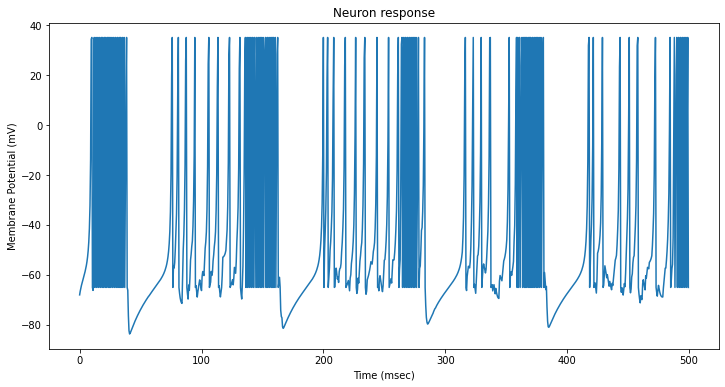

In [ ]:
plt.rcParams["figure.figsize"] =(12,6)
plt.figure()
plt.title('Neuron response')
plt.ylabel('Membrane Potential (mV)')
plt.xlabel('Time (msec)')
plt.plot(dt*np.arange(steps), v_out[:,1])

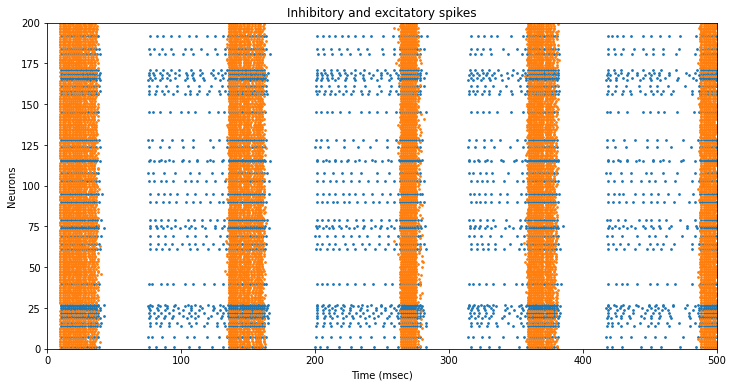

In [ ]:
plt.rcParams["figure.figsize"] =(12,6)
# Split between inhibitory and excitatory
inh_v_out = np.where(p_neurons < 0.2, v_out, 0)
exc_v_out = np.where(p_neurons >= 0.2, v_out, 0)
# Identify spikes
inh_spikes = np.argwhere(inh_v_out == 35.0)
exc_spikes = np.argwhere(exc_v_out == 35.0)
# Display spikes over time
plt.axis([0, T, 0, n])
plt.title('Inhibitory and excitatory spikes')
plt.ylabel('Neurons')
plt.xlabel('Time (msec)')
# Plot inhibitory spikes
steps, neurons = inh_spikes.T
plt.scatter(steps*dt, neurons, s=3)
# Plot excitatory spikes
steps, neurons = exc_spikes.T
plt.scatter(steps*dt, neurons, s=3)

In [ ]:
plt.rcParams["figure.figsize"] =(12,6)
spikes = np.argwhere(v_out >= 35.0)
plt.axis([0, T, 0, n])
plt.title('spikes')
plt.ylabel('Neurons')
plt.xlabel('Time (msec)')
steps, neurons = spikes.T
plt.scatter(steps*dt, neurons, s=3)


In [ ]:
"""
n = 10
A = np.full((n), 0.02, dtype=np.float32)
B = np.full((n), 0.2, dtype=np.float32)
C = np.full((n), -65.0, dtype=np.float32)
D = np.full((n), 8.0, dtype=np.float32)
G_syn = np.full((n), 0.1, dtype=np.float32)
E_syn = np.full((n), 0.0, dtype=np.float32)
K_syn = np.full((n), 0.2, dtype=np.float32)
spiking_thres = 35
resting_potential = -70
p = 0.8

def adj_mat_generator(n, p):
  adj_m = tf.random_uniform([n, n], dtype=tf.float32)
  adj_m = tf.where(adj_m < tf.constant(p, shape=[n,n], dtype=tf.float32), tf.ones([n,n], dtype=tf.float32), tf.zeros([n,n], dtype=tf.float32))
  return adj_m



graph1 = tf.Graph()
with graph1.as_default():
  
  I = tf.placeholder(tf.float32, shape=[n])
  dt = tf.placeholder(tf.float32)
  adj_mat = tf.Variable(adj_mat_generator(n, p), name='adj_mat')
  adj_mat = tf.linalg.set_diag(adj_mat, tf.zeros([n], dtype=tf.float32))
  
  
with tf.Session(graph=graph1) as sess:
  #sess.run(tf.initialize_all_variables())
  sess.run(tf.global_variables_initializer())
  print(adj_mat.eval()) 

"""
  